In [25]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [37]:
from sklearn import __version__ as sklearn_version
print(f"sklearn version : {sklearn_version}")


sklearn version : 1.2.2


In [26]:
data_file_paths = [f'../data/raw/Churn_Modelling_{country}.csv'  for country in ['Spain', 'France']]
print(f'file data paths: {data_file_paths}')


file data paths: ['../data/raw/Churn_Modelling_Spain.csv', '../data/raw/Churn_Modelling_France.csv']


In [38]:
df = pd.concat([pd.read_csv(fpath) for fpath in data_file_paths])
df.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
1,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
2,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
3,15737173,Andrews,497,Spain,Male,24,3,0.00,2,1,0,76390.01,0
4,15600882,Scott,635,Spain,Female,35,7,0.00,2,1,1,65951.65,0
5,15788218,Henderson,549,Spain,Female,24,9,0.00,2,1,1,14406.41,0
6,15661507,Muldrow,587,Spain,Male,45,6,0.00,1,0,0,158684.81,0
7,15597945,Dellucci,636,Spain,Female,32,8,0.00,2,1,0,138555.46,0
8,15699309,Gerasimov,510,Spain,Female,38,4,0.00,1,1,0,118913.53,1
9,15589475,Azikiwe,591,Spain,Female,39,3,0.00,3,1,0,140469.38,1


In [39]:
df.shape

(7491, 13)

In [40]:
# Are there missing values?
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [31]:
df['Geography'].value_counts()

Geography
France    5014
Spain     2477
Name: count, dtype: int64

In [32]:
feat_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

In [33]:
X, y = df[feat_cols], df[targ_col]
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [34]:
y.mean()

0.16326258176478442

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"X: {X.shape}")
## print data type of X_train
print(f"X_train: {type(X_train)}")
## same for y_train
print(f"y_train: {type(y_train)}")

X_train: (5618, 8)
X_test: (1873, 8)
y_train: (5618,)
y_test: (1873,)
X: (7491, 8)
X_train: <class 'pandas.core.frame.DataFrame'>
y_train: <class 'pandas.core.series.Series'>


In [45]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

clf = RandomForestClassifier(random_state=random_state, 
                            **train_params)
model = Pipeline(
    steps=[("preprocessor", SimpleImputer()), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [46]:
y_prob = model.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
print(f"F1 Score: {f1:.3f}, ROC AUC Score: {roc_auc:.3f}")


F1 Score: 0.547, ROC AUC Score: 0.868


Info from [confusion_matrix definition](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

By definition a confusion matrix $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$

confusion matrix: [[0.98 0.02]
 [0.59 0.41]]
first row: [0.98 0.02]


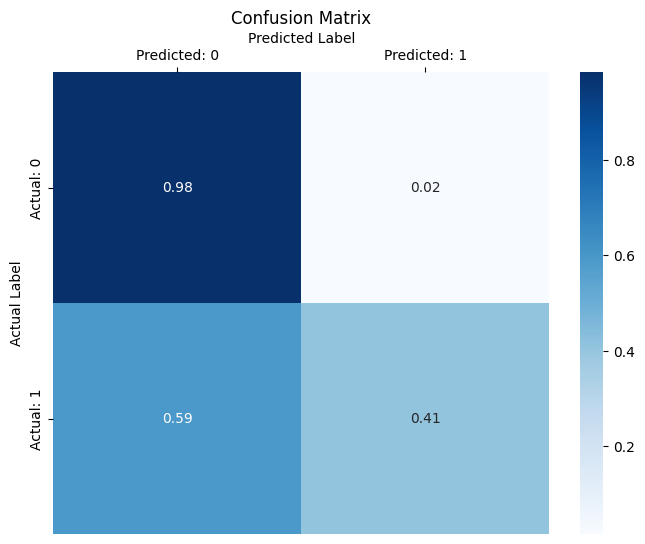

In [68]:
cm = confusion_matrix(y_test, y_pred, normalize='true') 
print(f'confusion matrix: {cm.round(2)}')
print(f'first row: {cm[0].round(2)}')
# Create the heatmap with better axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='.2f', 
            xticklabels=['Predicted: 0', 'Predicted: 1'], 
            yticklabels=['Actual: 0', 'Actual: 1'])

# Add labels and title for clarity
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
# Move x-axis labels to the top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

plt.show()

In [63]:
out_feat_names = model[:-1].get_feature_names_out(feat_cols)
out_feat_names

array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], dtype=object)

[ELI5](https://pypi.org/project/eli5/) is a Python package which helps to debug machine learning classifiers and explain their predictions.

In [70]:
import eli5
from sklearn.metrics import make_scorer
from eli5.sklearn import PermutationImportance


preprocessor = model.named_steps['preprocessor']
clf = model.named_steps['clf']
X_test_transformed = preprocessor.transform(X_test)

perm = PermutationImportance(clf, scoring=make_scorer(f1_score), random_state=random_state).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names=out_feat_names)

Weight,Feature
0.2444 ± 0.0285,Age
0.1816 ± 0.0108,NumOfProducts
0.1365 ± 0.0315,IsActiveMember
0.0326 ± 0.0050,Balance
0.0215 ± 0.0136,Tenure
0.0143 ± 0.0118,CreditScore
0.0057 ± 0.0124,EstimatedSalary
0.0002 ± 0.0083,HasCrCard


In [71]:
feat_imp = zip(X_test.columns.tolist(), perm.feature_importances_)
df_feat_imp = pd.DataFrame(feat_imp, 
                    columns=['feature', 'importance'])
df_feat_imp = df_feat_imp.sort_values(by='importance', ascending=False)
df_feat_imp

,feature,importance
1,Age,0.244377
4,NumOfProducts,0.181561
6,IsActiveMember,0.136543
3,Balance,0.032561
2,Tenure,0.021488
0,CreditScore,0.014311
7,EstimatedSalary,0.005650
5,HasCrCard,0.000152


In [72]:
feat_importance_fpath = '../reports/feat_imp.csv'
df_feat_imp.to_csv(feat_importance_fpath, index=False)

In [73]:
from joblib import dump

dump(model, '../models/clf-model.joblib');